# Loading Libraries




In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction import extract_features
np.warnings.filterwarnings('ignore')

In [2]:
gc.enable()

train = pd.read_csv('../input/training_set.csv')

# Features to compute with tsfresh library. Fft coefficient is meant to capture periodicity
fcp = {'fft_coefficient': [{'coeff': 0, 'attr': 'abs'},{'coeff': 1, 'attr': 'abs'}],
#                           {'coeff': 2, 'attr': 'abs'},{'coeff': 3, 'attr': 'abs'}],
        'kurtosis' : None, 'skewness' : None,
        'maximum':None, 'minimum':None, 'mean':None,
       'sample_entropy':None,'sum_values':None,'longest_strike_above_mean':None,
    'length':None, 'longest_strike_below_mean':None,}
flux_dic={ 'longest_strike_above_mean':None, 'length':None }

flux_by_flux_dict={'longest_strike_above_mean': None,
            'longest_strike_below_mean': None, 'kurtosis' : None,  'mean_change': None,
          'mean_abs_change': None  }



def featurize(df):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']


    aggs = {
        'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
        'detected': ['mean'],
        'flux_ratio_sq':['sum','skew'],
        'flux_by_flux_ratio_sq':['sum','skew'],
    }

    agg_df = df.groupby(['object_id']).agg(aggs)
    new_columns = [
        k + '_' + agg for k in aggs.keys() for agg in aggs[k]
    ]
    agg_df.columns = new_columns
    agg_df['flux_diff'] = agg_df['flux_max'] - agg_df['flux_min']

    agg_df['flux_dif2'] = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_mean']
    agg_df['flux_w_mean'] = agg_df['flux_by_flux_ratio_sq_sum'] / agg_df['flux_ratio_sq_sum']
    agg_df['flux_dif3'] = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_w_mean']
    agg_df_ts = extract_features(df, column_id='object_id', column_sort='mjd', column_kind='passband', column_value = 'flux', default_fc_parameters = fcp, n_jobs=4)
    df_det = df[df['detected']==1].copy()
    agg_df_mjd = extract_features(df_det, column_id='object_id', column_value = 'mjd', default_fc_parameters = {'maximum':None, 'minimum':None}, n_jobs=4)
    agg_df_mjd['mjd_diff_det'] = agg_df_mjd['mjd__maximum'] - agg_df_mjd['mjd__minimum']
    
    
    del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum']
    agg_df_ts = pd.merge(agg_df_ts, agg_df_mjd, on = 'id')
    
    agg_flux_d=extract_features(df, column_id='object_id',column_value='flux',default_fc_parameters=flux_dic, n_jobs=4)
    #agg_flux_by_d=extract_features(df, column_id='object_id',column_value='flux_by_flux_ratio_sq',default_fc_parameters=flux_by_flux_dict, n_jobs=4)
    agg_flux_d.index.rename('object_id', inplace=True)
    #agg_flux_by_d.index.rename('object_id', inplace=True)
    agg_df_ts.index.rename('object_id',inplace=True)
    agg_df_tss=pd.concat([agg_flux_d, agg_df_ts], axis=1)
    maxtime=df.loc[df.groupby(['object_id'])["flux"].idxmax()]['mjd']
    mintime=df.loc[df.groupby(['object_id'])["flux"].idxmin()]['mjd']
    agg_df['time_dif']=maxtime.values-mintime.values
    agg_df = pd.merge(agg_df, agg_df_tss, on='object_id')
    
    return agg_df

agg_train = featurize(train)

Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


# Merging features with meta data

In [6]:
meta_train = pd.read_csv('../input/training_set_metadata.csv')
meta_train.head()
#######Add new features
def add_feat(df):
    df['photoz_ratio_sq'] = np.power(df['hostgal_photoz'] / df['hostgal_photoz_err'], 2.0)
    df['photoz_by_photoz_ratio_sq'] = df['hostgal_photoz'] * df['photoz_ratio_sq']
    return df

meta_train=add_feat(meta_train)

full_train = agg_train.reset_index().merge(
    right=meta_train,
    how='left',
    on='object_id'
)

def add_new(df):

    df['mjd_photoz_ratio']=(df['mjd_diff_det']/df['hostgal_photoz'].max())
    df['distmod_rt']=(df['mjd_diff_det']/(df['distmod']))
    
    df['photo_distmod']=(df['distmod']/(df['hostgal_photoz']))
    df['distmod_median']=np.power(df['distmod']-df['flux_median'],2)#

    df['photoz_flux']=df['hostgal_photoz']+df['flux_skew']
    df['mwebv_flux']=(df['mwebv']+df['flux_max']).abs()/(df['mjd_diff_det'])#
    df['flux_all']=df['flux_max'].max()-df['flux_max']/(df['flux_mean'])
    df['mwebv_hostgal']=(df['mwebv']+df['flux_mean']).abs()/(df['mjd_diff_det'])#

    df['dist_ch']=(df['distmod'].mean()-df['distmod']).abs()
    df['dist_cm']=(df['distmod'].max()-df['distmod'])###new important
    df['distmod_rtm']=(df['mjd_diff_det']/(df['dist_ch']))

    df['host_minmean']=(df['hostgal_photoz'].mean()-df['hostgal_photoz'])
    df['host_max_mi']=(df['hostgal_photoz'].max()-df['hostgal_photoz'])

            
        ##Features for passbands
    for i in range(6):
        df['qshift2_'+str(i)]=((df['flux_max'])-(df[str(i)+'__maximum']))/(df['flux_mean'])
        df['apshift2_'+str(i)]=((df['flux_max'])-(df['flux_min']))/(((df[str(i)+'__maximum'])-(df[str(i)+'__minimum'])))
        df['6mb'+str(i)]=(df['flux_mean']-df[str(i)+'__mean'])/(df['flux_mean'])
        df['6mmb'+str(i)]=(df['flux_max']-df[str(i)+'__maximum'])/(df['flux_max'])
    
    
    for i in range(6):
        for j in range(i+1,6):
            df['Pass'+str(i)+'max_sub_pass'+str(j)+'max']=(df[str(i)+'__maximum']-df[str(j)+'__maximum'])/(df['flux_max'])
            df['Pass'+str(i)+'mean_sub_pass'+str(j)+'mean']=(df[str(i)+'__mean']-df[str(j)+'__mean'])/(df['flux_mean'])
            df['Pass'+str(i)+'max_sub_pass'+str(j)+'max_Dmean']=(df[str(i)+'__maximum']-df[str(j)+'__maximum'])/(df['flux_mean'])
            df['Pass'+str(i)+'mean_sub_pass'+str(j)+'mean_Dmax']=(df[str(i)+'__mean']-df[str(j)+'__mean'])/(df['flux_max'])
  
    df['time_dif']=df['time_dif'].abs()
    
    for i in range(6):
        df['Pass'+str(i)+'_mult_ELM']=((df[str(i)+'__sample_entropy'])*(df[str(i)+'__longest_strike_above_mean'])*df[str(i)+'__mean'])
        df['Max_sub_Pass'+str(i)+'max_Dstd']=((df['flux_max'])-(df[str(i)+'__maximum']))/(df['flux_std'])

    
   
    del df['0__maximum'],df['1__maximum'],df['2__maximum'],df['3__maximum'],df['4__maximum'],df['5__maximum']
    del df['0__minimum'],df['1__minimum'],df['2__minimum'],df['3__minimum'],df['4__minimum'],df['5__minimum']
    del df['0__mean'],df['1__mean'],df['2__mean'],df['3__mean'],df['4__mean'],df['5__mean']
    del df['0__length'],df['1__length'],df['2__length'],df['3__length'],df['4__length'],df['5__length']
    del df['0__longest_strike_below_mean'],df['1__longest_strike_below_mean'],df['2__longest_strike_below_mean'],df['3__longest_strike_below_mean'],df['4__longest_strike_below_mean'],df['5__longest_strike_below_mean']
    
    return df

 

if 'target' in full_train:
    y = full_train['target']
classes = sorted(y.unique())

full_train=add_new(full_train)
# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'],full_train['distmod'],full_train['hostgal_specz']
    del full_train['gal_l'],full_train['gal_b'],full_train['ddf']
    
train_mean = full_train.mean(axis=0)
full_train.fillna(0, inplace=True)
full_trainc=full_train.copy()

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [7]:
del full_train['ra'], full_train['decl'],full_train['time_dif'], full_train['target']

In [8]:
##After 3 Feature Elimination Del Features
del_3={'0__fft_coefficient__coeff_0__attr_"abs"',
 '0__fft_coefficient__coeff_1__attr_"abs"',
 '0__kurtosis',
 'Pass3max_sub_pass5max',
 'Pass4max_sub_pass5max',
 'Pass0mean_sub_pass1mean',
 'Pass0mean_sub_pass2mean',
 'Pass0mean_sub_pass4mean',
 'Pass0mean_sub_pass5mean',
 'Pass1mean_sub_pass3mean',
 'Pass1mean_sub_pass4mean',
 'Pass1mean_sub_pass5mean',
 'Pass2mean_sub_pass3mean',
 'Pass2mean_sub_pass5mean',
 'Pass3mean_sub_pass4mean',
 'Pass3mean_sub_pass5mean',
 'Pass4mean_sub_pass5mean',
 'Pass0max_sub_pass1max_Dmean',
 'Pass0max_sub_pass2max_Dmean',
 'Pass0max_sub_pass3max_Dmean',
 'Pass0max_sub_pass4max_Dmean',
 'Pass0max_sub_pass5max_Dmean',
 'Pass1max_sub_pass3max_Dmean',
 'Pass1max_sub_pass4max_Dmean',
 'Pass1max_sub_pass5max_Dmean',
 'Pass2max_sub_pass4max_Dmean',
 'Pass2max_sub_pass5max_Dmean',
 'Pass3max_sub_pass5max_Dmean',
 'Pass4max_sub_pass5max_Dmean',
 'Pass0mean_sub_pass1mean_Dmax',
 'Pass0mean_sub_pass2mean_Dmax',
 'Pass0mean_sub_pass3mean_Dmax',
 'Pass0mean_sub_pass4mean_Dmax',
 'Pass0mean_sub_pass5mean_Dmax',
 'Pass1mean_sub_pass2mean_Dmax',
 'Pass1mean_sub_pass3mean_Dmax',
 'Pass1mean_sub_pass4mean_Dmax',
 'Pass1mean_sub_pass5mean_Dmax',
 'Pass2mean_sub_pass3mean_Dmax',
 'Pass2mean_sub_pass4mean_Dmax',
 'Pass2mean_sub_pass5mean_Dmax',
 'Pass3mean_sub_pass4mean_Dmax',
 'Pass3mean_sub_pass5mean_Dmax',
 'Pass4mean_sub_pass5mean_Dmax',
 '4__sample_entropy',
 '5__sum_values',
 '6mb1',
 '6mb3',
 '6mb4',
 '6mb5',
 '6mmb2',
 '6mmb3',
 '6mmb5',
 'Pass0max_sub_pass2max',
 'Pass0max_sub_pass4max',
 'Pass0max_sub_pass5max',
 'Pass1max_sub_pass4max',
 'Pass1max_sub_pass5max',
 'Pass2max_sub_pass5max',
 'apshift2_3',
 'apshift2_4',
 'flux__length',
 'flux_dif2',
 'flux_diff',
 'qshift2_2',
 'qshift2_5'}


del_2={'0__fft_coefficient__coeff_0__attr_"abs"',
 '0__kurtosis',
 'Pass4max_sub_pass5max',
 'Pass0mean_sub_pass1mean',
 'Pass0mean_sub_pass5mean',
 'Pass1mean_sub_pass4mean',
 'Pass2mean_sub_pass3mean',
 'Pass2mean_sub_pass5mean',
 'Pass3mean_sub_pass4mean',
 'Pass4mean_sub_pass5mean',
 'Pass0max_sub_pass1max_Dmean',
 'Pass0max_sub_pass4max_Dmean',
 'Pass0max_sub_pass5max_Dmean',
 'Pass1max_sub_pass3max_Dmean',
 'Pass1max_sub_pass4max_Dmean',
 'Pass1max_sub_pass5max_Dmean',
 'Pass2max_sub_pass4max_Dmean',
 'Pass2max_sub_pass5max_Dmean',
 'Pass3max_sub_pass5max_Dmean',
 'Pass4max_sub_pass5max_Dmean',
 '4__sample_entropy',
 '5__sum_values',
 '6mb3',
 '6mb4',
 '6mb5',
 '6mmb2',
 '6mmb3',
 '6mmb5',
 'Pass0max_sub_pass2max',
 'Pass0max_sub_pass3max',
 'Pass0max_sub_pass5max',
 '8mmb3',
 '8mmb4',
 'apshift2_3',
 'apshift2_4',
 'flux__length',
 'flux_dif2',
 'flux_diff',
 'qshift2_2',
 'qshift2_5'}


delete_cols=['0__longest_strike_above_mean', '0__sum_values',
'1__fft_coefficient__coeff_0__attr_"abs"',
 '1__longest_strike_above_mean',
 '1__sum_values',
 '2__fft_coefficient__coeff_0__attr_"abs"',
 '2__sum_values',
 '3__fft_coefficient__coeff_0__attr_"abs"',
 '3__fft_coefficient__coeff_1__attr_"abs"',
 '3__longest_strike_above_mean',
 '3__sum_values',
 '4__fft_coefficient__coeff_0__attr_"abs"',
 '4__longest_strike_above_mean',
 '4__sum_values',
 '5__longest_strike_above_mean',
 '5__skewness',
 '6mmb4',
 'flux_ratio_sq_sum',
 'mwebv',
 'qshift2_3',
 'qshift2_4',
 'flux_by_flux_ratio_sq_sum',
 'flux_err_max',
 'flux_err_median',
 'flux_err_skew',
 'flux_mean']

In [9]:
full_train.drop(delete_cols, inplace=True, axis=1)
full_train.drop(del_3, inplace=True, axis=1)
full_train.shape

(7848, 88)

# Class weights and loss functions

In [10]:
# Compute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}

def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False


def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 12))
    sns.barplot(x='gain', y='feature', data=importances_.sort_values('mean_gain', ascending=False))
    plt.tight_layout()
    plt.savefig('importances.png')

# 5-fold lgb training


In [11]:
full_train.shape

(7848, 88)

In [12]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
clfs = []
importances = pd.DataFrame()
lgb_params = {
    'device': 'cpu', 
    'objective': 'multiclass', 
    'num_class': 14, 
    'boosting_type': 'gbdt', 
    'n_jobs': -1, 
    'max_depth': 4, #4,7 
    'n_estimators': 1000, 
    'subsample_freq': 2, 
    'subsample_for_bin': 5000, 
    'min_data_per_group': 100, 
    'max_cat_to_onehot': 4, 
    'cat_l2': 1.0, 
    'cat_smooth': 59.5, 
    'max_cat_threshold': 32, 
    'metric_freq': 10, 
    'verbosity': -1, 
    'metric': 'multi_logloss', 
    'xgboost_dart_mode': False, 
    'uniform_drop': False, 
    'colsample_bytree': 0.5, 
    'drop_rate': 0.173, 
    'learning_rate': 0.0267, #0.0267
    'max_drop': 5, 
    'min_child_samples': 10, 
    'min_child_weight': 100.0, 
    'min_split_gain': 0.1, 
    'num_leaves': 7, 
    'reg_alpha': 0.1, 
    'reg_lambda': 0.00023, 
    'skip_drop': 0.44, 
    'subsample': 0.75
}

# Compute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}

oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
    val_x, val_y = full_train.iloc[val_], y.iloc[val_]
    
    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=100,
        early_stopping_rounds=100,
        sample_weight=trn_y.map(weights)
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    print(multi_weighted_logloss(val_y, oof_preds[val_, :]))

    imp_df = pd.DataFrame()
    imp_df['feature'] = full_train.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)

    clfs.append(clf)

print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.672675	training's wloss: 0.660294	valid_1's multi_logloss: 0.996239	valid_1's wloss: 0.797869
[200]	training's multi_logloss: 0.424873	training's wloss: 0.413006	valid_1's multi_logloss: 0.765808	valid_1's wloss: 0.593984
[300]	training's multi_logloss: 0.3278	training's wloss: 0.317104	valid_1's multi_logloss: 0.683641	valid_1's wloss: 0.540523
[400]	training's multi_logloss: 0.271727	training's wloss: 0.261623	valid_1's multi_logloss: 0.642863	valid_1's wloss: 0.523125
[500]	training's multi_logloss: 0.232239	training's wloss: 0.222515	valid_1's multi_logloss: 0.615736	valid_1's wloss: 0.514857
[600]	training's multi_logloss: 0.202067	training's wloss: 0.192983	valid_1's multi_logloss: 0.596217	valid_1's wloss: 0.515546
Early stopping, best iteration is:
[509]	training's multi_logloss: 0.229141	training's wloss: 0.219457	valid_1's multi_logloss: 0.61341	valid_1's wloss: 0.514289
0.5142887

# Evaluation
features' importance and confusion matrix

Normalized confusion matrix


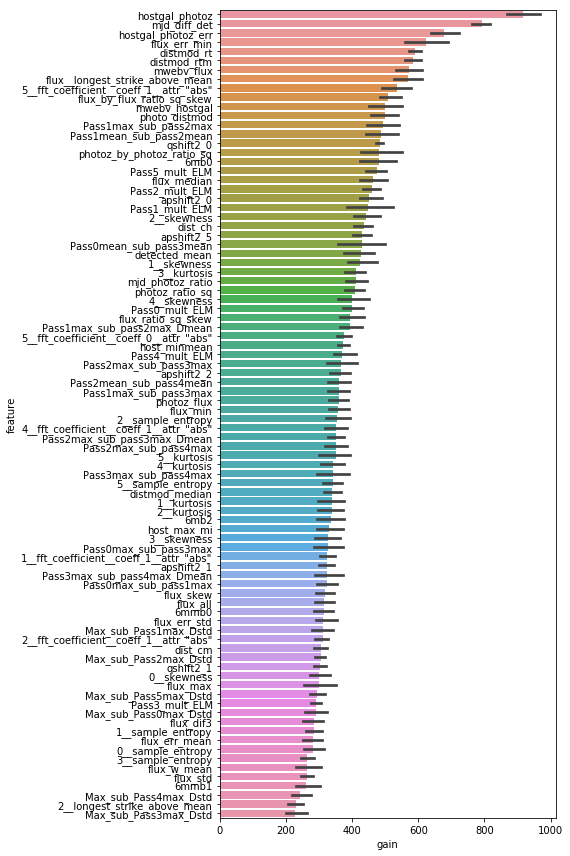

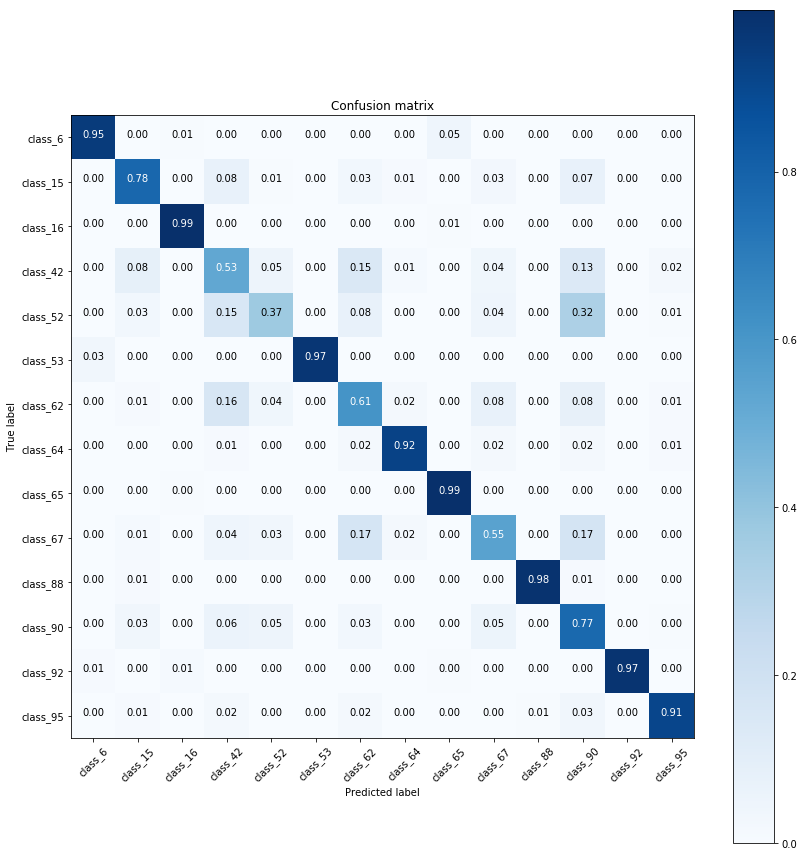

In [13]:
save_importances(importances_=importances)
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv('../input/sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

# Test Set Predictions

In [ ]:
# full['difference_mean'].value_counts()

In [14]:
def GenUnknown(data):
    return ((((((data["mymedian"]) + (((data["mymean"]) / 2.0)))/2.0)) + (((((1.0) - (((data["mymax"]) * (((data["mymax"]) * (data["mymax"]))))))) / 2.0)))/2.0)

def predict_chunk(df_, clfs_, meta_, features, train_mean):
    agg_ = featurize(df_)
    full_test = agg_.reset_index().merge(
        right=meta_,
        how='left',
        on='object_id'
    )
    
    full_test=add_new(full_test)
    full_test = full_test.fillna(0)
    preds_ = None
    for clf in clfs_:
        if preds_ is None:
            preds_ = clf.predict_proba(full_test[features]) / len(clfs_)
        else:
            preds_ += clf.predict_proba(full_test[features]) / len(clfs_)

    preds_99 = np.ones(preds_.shape[0])
    for i in range(preds_.shape[1]):
        preds_99 *= (1 - preds_[:, i])

    # Create DataFrame from predictions
    preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs_[0].classes_])
    preds_df_['object_id'] = full_test['object_id']
    preds_df_['class_99'] = 0.18 * preds_99 / np.mean(preds_99) 
    return preds_df_

In [ ]:
meta_test = pd.read_csv('../input/test_set_metadata.csv')

meta_test=add_feat(meta_test)
import time
start = time.time()
chunks = 5000000
remain_df = None

for i_c, df in enumerate(pd.read_csv('../input/test_set.csv', chunksize=chunks, iterator=True)):
    unique_ids = np.unique(df['object_id'])
    new_remain_df = df.loc[df['object_id'] == unique_ids[-1]].copy()
    if remain_df is None:
        df = df.loc[df['object_id'].isin(unique_ids[:-1])]
    else:
        df = pd.concat([remain_df, df.loc[df['object_id'].isin(unique_ids[:-1])]], axis=0)
    # Create remaining samples df
    remain_df = new_remain_df
    preds_df = predict_chunk(df_=df,
                             clfs_=clfs,
                             meta_=meta_test,
                             features=full_train.columns,
                             train_mean=train_mean)

    if i_c == 0:
        preds_df.to_csv('predictions10.csv', header=True, mode='a', index=False)
    else:
        preds_df.to_csv('predictions10.csv', header=False, mode='a', index=False)

    del preds_df
    gc.collect()
    
    print('%15d done in %5.1f minutes' % (chunks * (i_c + 1), (time.time() - start) / 60), flush=True)

# Compute last object in remain_df
preds_df = predict_chunk(df_=remain_df,
                         clfs_=clfs,
                         meta_=meta_test,
                         features=full_train.columns,
                         train_mean=train_mean)

preds_df.to_csv('predictions10.csv', header=False, mode='a', index=False)

In [ ]:
z = pd.read_csv('predictions10.csv')
print("Shape BEFORE grouping:",z.shape)
z = z.groupby('object_id').mean()
print("Shape AFTER grouping:",z.shape)
z.to_csv('single_predictions50.csv', index=True)